# Introduction

This notebook implements Adaboost with decision stumps as base learner from scratch. The implementation is adapted from [MLfromscratch](https://github.com/patrickloeber/MLfromscratch).

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

## Weak Learner (Decision Stump)

## Error

\begin{aligned}
\epsilon_t = \frac{misclassification}{samples} = \frac{misclassification}{N}
\end{aligned}

if $\epsilon>0.5$, just flip the decision and the error is $1-\epsilon$.

## Weights
\begin{aligned}
w_{i+1} = \frac{w_i exp^{-\alpha y_i h(x_i)}}{\sum_i w_i}
\end{aligned}

where $h(x_i)$ is the prediction of $x_i$.

## Performance

\begin{aligned}
\alpha = 0.5\log(\frac{1-\epsilon_t}{\epsilon_t})
\end{aligned}

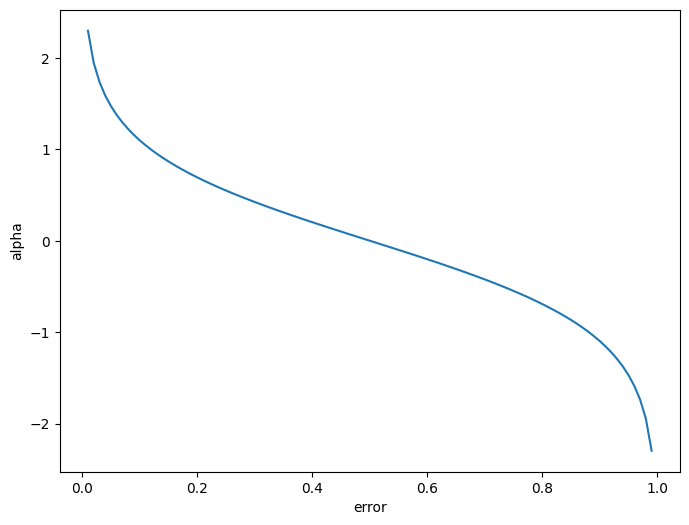

In [1]:
alpha = lambda x : 0.5 * np.log((1.0-x) / x)
error = np.arange(0.01, 1.00, 0.01)

plt.figure(figsize=(8, 6))
plt.xlabel('error')
plt.ylabel('alpha')
plt.plot(error, alpha(error))
plt.show()

## Prediction

\begin{aligned}
y_i = sign(\sum_t \alpha_t h(x_i))
\end{aligned}

## Training

Initialize weights for each sample to $\frac{1}{N}$. \\
for $t$ in $T$:
  - Train week classifier (greedy search for best feature and threshold)
  - Calculate error $\epsilon_t = \sum_{miss} weights$. (flip error and decision if $\epsilon>0.5$)
  - Calculate $\alpha = 0.5 \log(\frac{1-\epsilon_t}{\epsilon_t})$
  - Update weights $w_{i+1}= \frac{w_i exp^{-\alpha y_i h(x_i)}}{\sum_i w_i}$


## Implementation

In [2]:
# Decision stump used as weak classifier
class DecisionStump():
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions

In [3]:
class Adaboost():

    def __init__(self, n_clf=5):
        self.n_clf = n_clf

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []
        # Iterate through classifiers
        for _ in range(self.n_clf):
            clf = DecisionStump()

            min_error = float('inf')
            # greedy search to find best threshold and feature
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    # predict with polarity 1
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    # Error = sum of weights of misclassified samples
                    misclassified = w[y != predictions]
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # store the best configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # calculate alpha
            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            # calculate predictions and update weights
            predictions = clf.predict(X)

            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred

## Test

In [7]:
data = datasets.load_breast_cancer()
X = data.data
y = data.target
y[y == 0] = -1

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [9]:
def accuracy(y_true, y_pred):
  return np.mean(y_true == y_pred)

In [10]:
clf = Adaboost(n_clf = 5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy(y_test, y_pred)
print(f'Accuracy: {acc}')

Accuracy: 0.9649122807017544
